In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, auc
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/pdc_dataset_with_target.csv')
print(df.shape)
df.head()

(41000, 8)


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,target
0,27.75,55.0,B,875.98,No,8,44.16,0
1,31.33,39.0,C,839.91,No,4,13.93,1
2,23.87,10.0,A,1364.70,Yes,4,15.16,0
3,35.64,34.0,C,1462.07,No,4,15.71,1
4,NaN,NaN,C,710.61,No,8,13.77,1


In [3]:
df.isna().sum()

,0
feature_1,2054
feature_2,2050
feature_3,0
feature_4,2054
feature_5,0
feature_6,0
feature_7,2036
target,0


In [4]:
df.describe()

,feature_1,feature_2,feature_4,feature_6,feature_7,target
count,38946.000000,38950.000000,38946.000000,41000.000000,38964.000000,41000.000000
mean,29.990843,49.436560,1092.312002,5.010732,23.145819,0.398000
std,5.000959,28.963859,1012.051699,2.582285,47.562436,0.489491
min,7.670000,0.000000,-155.620000,1.000000,0.000000,0.000000
25%,26.600000,25.000000,801.150000,3.000000,5.830000,0.000000
50%,30.000000,49.000000,1004.735000,5.000000,14.180000,0.000000
75%,33.390000,75.000000,1208.140000,7.000000,28.370000,1.000000
max,52.400000,99.000000,17643.400000,9.000000,1660.800000,1.000000


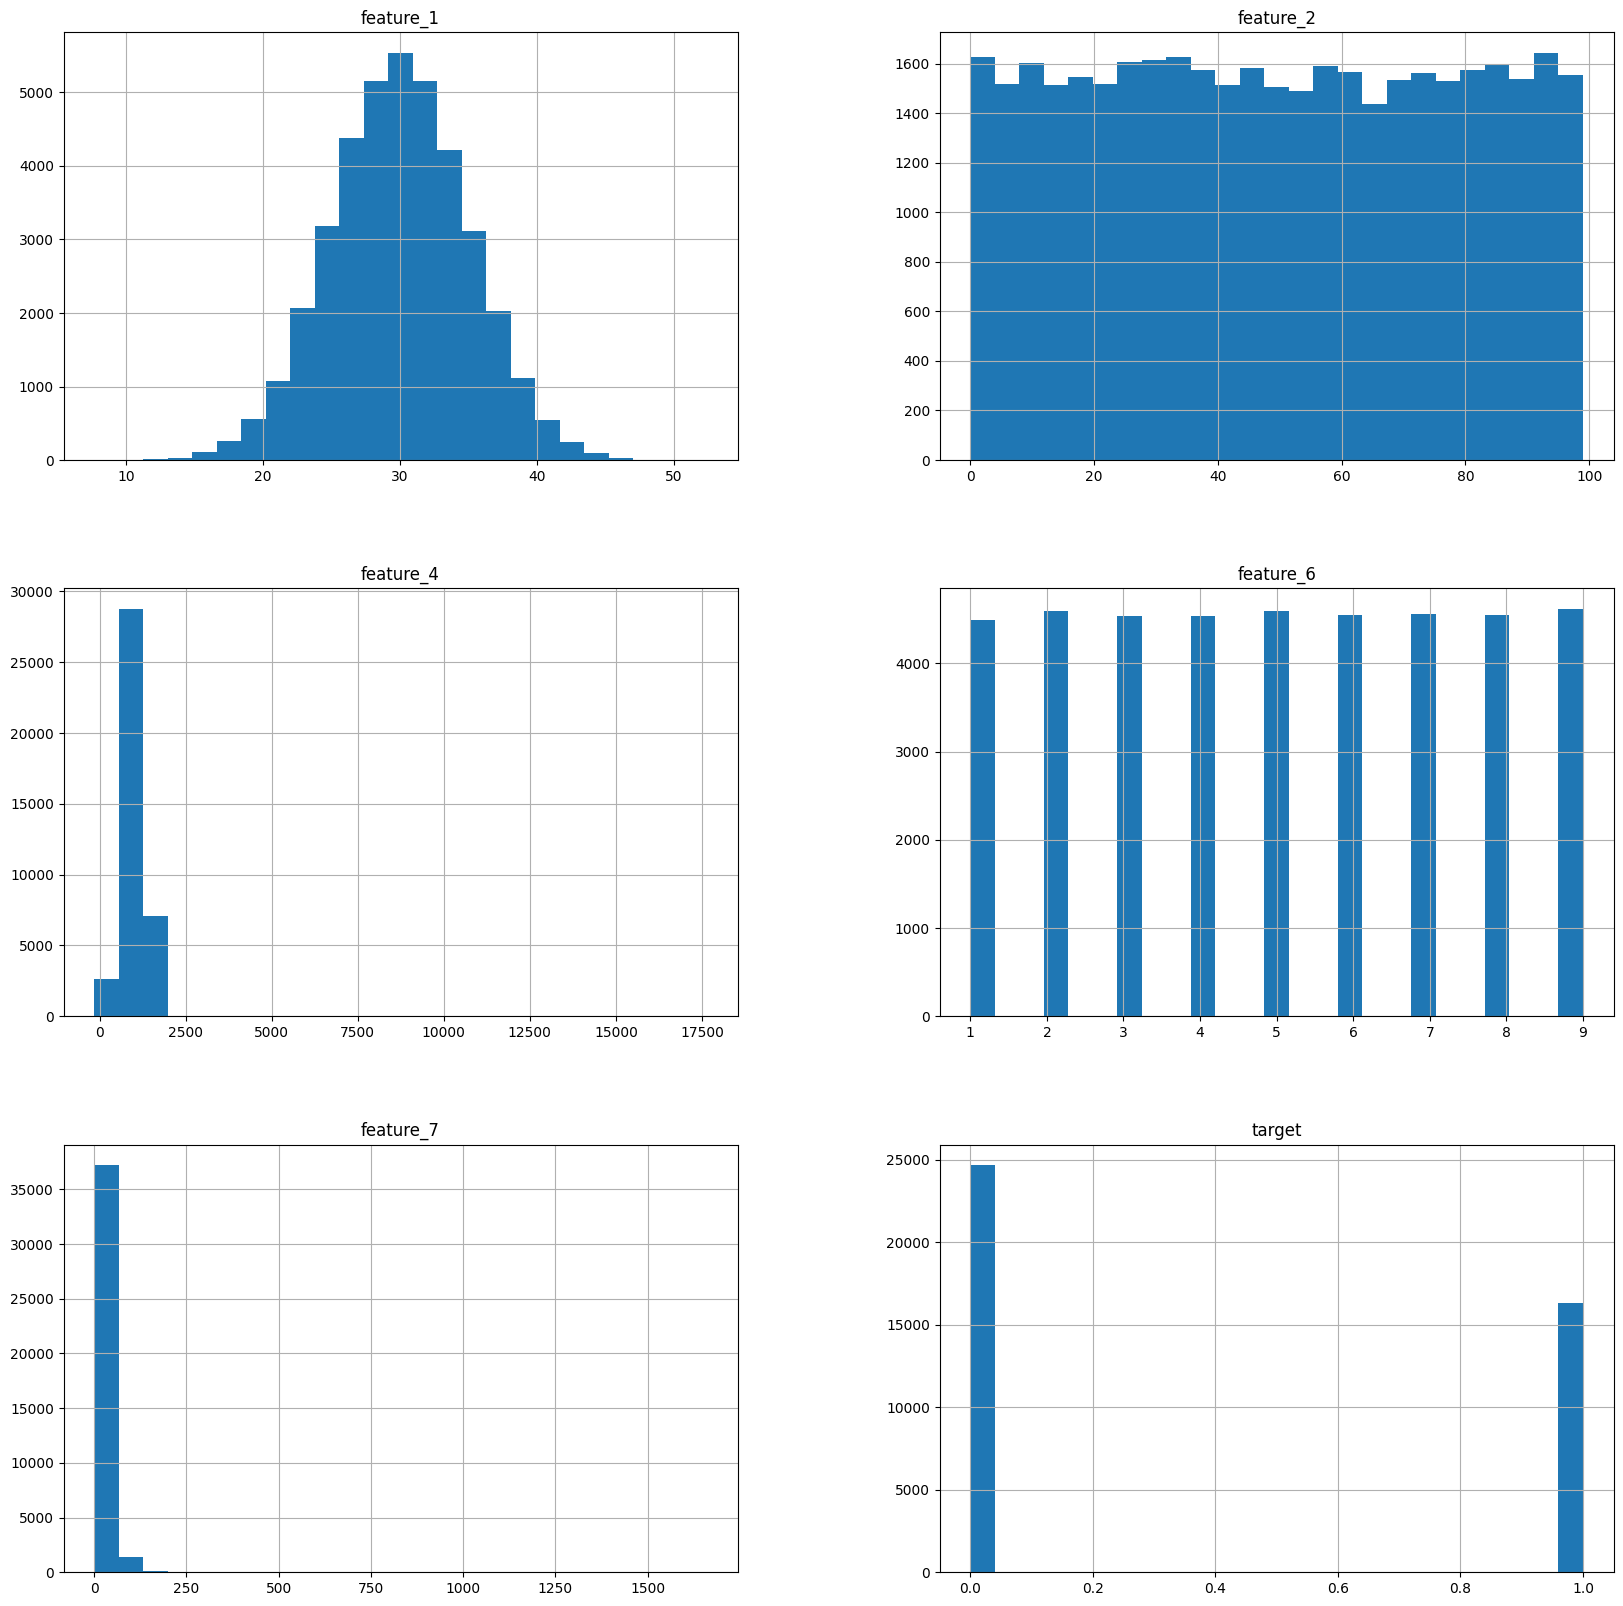

In [5]:
# Histogram of the each feature
df.hist(figsize=(20, 20), bins=25)
plt.show()

## Filling the missing values

- feature_1 and feature_2 are not much skewed so filling them with mean is suitable
- feature_4 and feature_7 should be filled with median

In [6]:
df.fillna({
    'feature_1': df['feature_1'].mean(),
    'feature_2': df['feature_2'].mean(),
    'feature_4': df['feature_4'].median(),
    'feature_7': df['feature_7'].median()
}, inplace=True)

In [7]:
print(df.shape)
df.head()

(41000, 8)


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,target
0,27.750000,55.00000,B,875.98,No,8,44.16,0
1,31.330000,39.00000,C,839.91,No,4,13.93,1
2,23.870000,10.00000,A,1364.70,Yes,4,15.16,0
3,35.640000,34.00000,C,1462.07,No,4,15.71,1
4,29.990843,49.43656,C,710.61,No,8,13.77,1


In [8]:
df['feature_3'].value_counts()

,count
feature_3,
A,13704
C,13680
B,13616


In [9]:
df['feature_5'].value_counts()

,count
feature_5,
Yes,20519
No,20481


In [10]:
df['feature_6'].value_counts()

,count
feature_6,
9,4618
5,4589
2,4587
7,4556
8,4547
6,4543
4,4537
3,4531
1,4492


In [11]:
df['target'].value_counts()

,count
target,
0,24682
1,16318


In [12]:
df.dtypes

,0
feature_1,float64
feature_2,float64
feature_3,object
feature_4,float64
feature_5,object
feature_6,int64
feature_7,float64
target,int64


First of all, let the categorical features be encoded

In [13]:
X = df.drop(columns=['target'])
y = df['target']

X_train_not_resampled, X_test, y_train_not_resampled, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_ohe = ohe.fit_transform(X_train_not_resampled[['feature_3', 'feature_5', 'feature_6']])
X_test_ohe = ohe.transform(X_test[['feature_3', 'feature_5', 'feature_6']])

qtr = QuantileTransformer()
X_train_qtr = qtr.fit_transform(X_train_not_resampled[['feature_1', 'feature_2', 'feature_4', 'feature_7']])
X_test_qtr = qtr.transform(X_test[['feature_1', 'feature_2', 'feature_4', 'feature_7']])

X_train_scaled_not_resampled = np.concatenate([X_train_qtr, X_train_ohe], axis=1)
X_test = np.concatenate([X_test_qtr, X_test_ohe], axis=1)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_scaled_not_resampled, y_train_not_resampled)

print(X_train_scaled_not_resampled.shape)
print(X_train.shape)
print(X_test.shape)

(30750, 18)
(36990, 18)
(10250, 18)


In [27]:
print("Training XGBoost Models...")

# --- XGBoost Serial
start_time = time.time()
xgb_serial = xgb.XGBClassifier(n_jobs=1, use_label_encoder=False, eval_metric='auc')
xgb_serial.fit(X_train, y_train)
serial_time = time.time() - start_time

# --- XGBoost Parallel CPU
start_time = time.time()
xgb_parallel = xgb.XGBClassifier(n_jobs=-1, use_label_encoder=False, eval_metric='auc')
xgb_parallel.fit(X_train, y_train)
parallel_time = time.time() - start_time

# --- XGBoost GPU
start_time = time.time()
xgb_gpu = xgb.XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', use_label_encoder=False, eval_metric='auc')
xgb_gpu.fit(X_train, y_train)
gpu_time = time.time() - start_time

Training XGBoost Models...


In [15]:
# building a deep learning pipeline and optimize it with Optimize the pipeline using one or more of the following: Parallel computing (multithreading, multiprocessing)
#  GPU acceleration (PyTorch, CUDA)

# Prepare datasets
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

# Define model
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),  # Output logits
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

'''# Class imbalance handling
class_counts = y_train.value_counts()
pos_weight_cpu = torch.tensor([class_counts[0] / class_counts[1]], device='cpu')  # for CPU
pos_weight_gpu = torch.tensor([class_counts[0] / class_counts[1]], device='cuda')  # for GPU
'''



"# Class imbalance handling\nclass_counts = y_train.value_counts()\npos_weight_cpu = torch.tensor([class_counts[0] / class_counts[1]], device='cpu')  # for CPU\npos_weight_gpu = torch.tensor([class_counts[0] / class_counts[1]], device='cuda')  # for GPU\n"

In [23]:
# ---------- CPU Training ----------
model_cpu = BinaryClassifier(X_train.shape[1]).to('cpu')
criterion_cpu = nn.BCELoss()
optimizer_cpu = optim.Adam(model_cpu.parameters(), lr=0.001)

start_time = time.time()
epochs = 50

for epoch in range(epochs):
    model_cpu.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        outputs = model_cpu(batch_X)
        loss = criterion_cpu(outputs, batch_y)
        optimizer_cpu.zero_grad()
        loss.backward()
        optimizer_cpu.step()
        running_loss += loss.item()
    print(f'CPU Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

cpu_train_time = time.time() - start_time

CPU Epoch 1/50, Loss: 0.6936
CPU Epoch 2/50, Loss: 0.6933
CPU Epoch 3/50, Loss: 0.6931
CPU Epoch 4/50, Loss: 0.6932
CPU Epoch 5/50, Loss: 0.6930
CPU Epoch 6/50, Loss: 0.6931
CPU Epoch 7/50, Loss: 0.6930
CPU Epoch 8/50, Loss: 0.6930
CPU Epoch 9/50, Loss: 0.6931
CPU Epoch 10/50, Loss: 0.6930
CPU Epoch 11/50, Loss: 0.6930
CPU Epoch 12/50, Loss: 0.6928
CPU Epoch 13/50, Loss: 0.6928
CPU Epoch 14/50, Loss: 0.6928
CPU Epoch 15/50, Loss: 0.6928
CPU Epoch 16/50, Loss: 0.6927
CPU Epoch 17/50, Loss: 0.6928
CPU Epoch 18/50, Loss: 0.6929
CPU Epoch 19/50, Loss: 0.6927
CPU Epoch 20/50, Loss: 0.6927
CPU Epoch 21/50, Loss: 0.6929
CPU Epoch 22/50, Loss: 0.6928
CPU Epoch 23/50, Loss: 0.6926
CPU Epoch 24/50, Loss: 0.6925
CPU Epoch 25/50, Loss: 0.6926
CPU Epoch 26/50, Loss: 0.6925
CPU Epoch 27/50, Loss: 0.6924
CPU Epoch 28/50, Loss: 0.6925
CPU Epoch 29/50, Loss: 0.6924
CPU Epoch 30/50, Loss: 0.6922
CPU Epoch 31/50, Loss: 0.6924
CPU Epoch 32/50, Loss: 0.6922
CPU Epoch 33/50, Loss: 0.6925
CPU Epoch 34/50, Lo

In [25]:
# ---------- GPU Training ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_gpu = BinaryClassifier(X_train.shape[1]).to(device)
criterion_gpu = nn.BCELoss()
optimizer_gpu = optim.Adam(model_gpu.parameters(), lr=0.001)

# Keep data on CPU for DataLoader
train_dataset_gpu = TensorDataset(X_train_tensor, y_train_tensor)
train_loader_gpu = DataLoader(train_dataset_gpu, batch_size=1024, shuffle=True, num_workers=8, pin_memory=True)

scaler = GradScaler()

start_time = time.time()

for epoch in range(epochs):
    model_gpu.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader_gpu:
        # Move batch to GPU inside the loop
        batch_X = batch_X.to(device, non_blocking=True)
        batch_y = batch_y.to(device, non_blocking=True)

        optimizer_gpu.zero_grad()
        #with autocast():
        outputs = model_gpu(batch_X)
        loss = criterion_gpu(outputs, batch_y)

        scaler.scale(loss).backward()
        scaler.step(optimizer_gpu)
        scaler.update()

        running_loss += loss.item()
    print(f'GPU Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader_gpu):.4f}')

gpu_train_time_nn = time.time() - start_time


GPU Epoch 1/50, Loss: 0.6933
GPU Epoch 2/50, Loss: 0.6932
GPU Epoch 3/50, Loss: 0.6932
GPU Epoch 4/50, Loss: 0.6931
GPU Epoch 5/50, Loss: 0.6931
GPU Epoch 6/50, Loss: 0.6931
GPU Epoch 7/50, Loss: 0.6931
GPU Epoch 8/50, Loss: 0.6930
GPU Epoch 9/50, Loss: 0.6930
GPU Epoch 10/50, Loss: 0.6930
GPU Epoch 11/50, Loss: 0.6931
GPU Epoch 12/50, Loss: 0.6930
GPU Epoch 13/50, Loss: 0.6929
GPU Epoch 14/50, Loss: 0.6928
GPU Epoch 15/50, Loss: 0.6928
GPU Epoch 16/50, Loss: 0.6927
GPU Epoch 17/50, Loss: 0.6927
GPU Epoch 18/50, Loss: 0.6929
GPU Epoch 19/50, Loss: 0.6927
GPU Epoch 20/50, Loss: 0.6928
GPU Epoch 21/50, Loss: 0.6926
GPU Epoch 22/50, Loss: 0.6927
GPU Epoch 23/50, Loss: 0.6926
GPU Epoch 24/50, Loss: 0.6926
GPU Epoch 25/50, Loss: 0.6925
GPU Epoch 26/50, Loss: 0.6925
GPU Epoch 27/50, Loss: 0.6926
GPU Epoch 28/50, Loss: 0.6925
GPU Epoch 29/50, Loss: 0.6922
GPU Epoch 30/50, Loss: 0.6923
GPU Epoch 31/50, Loss: 0.6925
GPU Epoch 32/50, Loss: 0.6922
GPU Epoch 33/50, Loss: 0.6920
GPU Epoch 34/50, Lo

In [28]:
def evaluate(model, X, y, framework="xgb"):
    if framework == "xgb":
        preds = model.predict(X)
    else:  # torch
        model.eval()
        with torch.no_grad():
            outputs = model(X)
            preds = (outputs > 0.5).float().cpu().numpy().astype(int)  # Threshold at 0.5
    acc = accuracy_score(y, preds)
    f1 = f1_score(y, preds)
    cm = confusion_matrix(y, preds)
    return acc, f1, cm

# Evaluate models
xgb_serial_results = evaluate(xgb_serial, X_test, y_test, framework="xgb")
xgb_parallel_results = evaluate(xgb_parallel, X_test, y_test, framework="xgb")
xgb_gpu_results = evaluate(xgb_gpu, X_test, y_test, framework="xgb")
pytorch_cpu_results = evaluate(model_cpu, X_test_tensor, y_test, framework="torch")
pytorch_gpu_results = evaluate(model_gpu, X_test_tensor.to(device), y_test, framework="torch")

# 6. Reporting
print("\n" + "="*40)
print("Model Evaluation Results")
print("="*40)
print(f"XGBoost Serial Training   ➔  Accuracy: {xgb_serial_results[0]:.4f} | F1-Score: {xgb_serial_results[1]:.4f} | Time: {serial_time:.2f} sec")
print(f"XGBoost Parallel (CPU)     ➔  Accuracy: {xgb_parallel_results[0]:.4f} | F1-Score: {xgb_parallel_results[1]:.4f} | Time: {parallel_time:.2f} sec")
print(f"XGBoost GPU Accelerated    ➔  Accuracy: {xgb_gpu_results[0]:.4f} | F1-Score: {xgb_gpu_results[1]:.4f} | Time: {gpu_time:.2f} sec")
print(f"PyTorch CPU Training       ➔  Accuracy: {pytorch_cpu_results[0]:.4f} | F1-Score: {pytorch_cpu_results[1]:.4f} | Time: {cpu_train_time:.2f} sec")
print(f"PyTorch GPU Accelerated    ➔  Accuracy: {pytorch_gpu_results[0]:.4f} | F1-Score: {pytorch_gpu_results[1]:.4f} | Time: {gpu_train_time_nn:.2f} sec")
print("="*40)



Model Evaluation Results
XGBoost Serial Training   ➔  Accuracy: 0.5208 | F1-Score: 0.4341 | Time: 0.37 sec
XGBoost Parallel (CPU)     ➔  Accuracy: 0.5208 | F1-Score: 0.4341 | Time: 0.35 sec
XGBoost GPU Accelerated    ➔  Accuracy: 0.5231 | F1-Score: 0.4341 | Time: 0.38 sec
PyTorch CPU Training       ➔  Accuracy: 0.5161 | F1-Score: 0.4287 | Time: 106.87 sec
PyTorch GPU Accelerated    ➔  Accuracy: 0.4988 | F1-Score: 0.4454 | Time: 35.86 sec


## Why GPU XGBoost is Not Faster Here
**Small Dataset Size:**
GPU benefits appear only with large datasets (typically 100,000+ samples). Small datasets cause overhead to dominate.

**Model Complexity:**
If trees are shallow and boosting rounds are low, CPU is already highly optimized and often faster.

**Kernel Launch Overhead:**
GPU needs to launch CUDA kernels for every task. For small jobs, this overhead becomes significant.

**Hardware Limitations:**
Kaggle GPUs like Tesla T4 or P100 are not extremely powerful compared to high-end CPUs.

**Data Movement Overhead:**
Even minimal CPU↔GPU data transfer causes noticeable delays for tiny datasets.

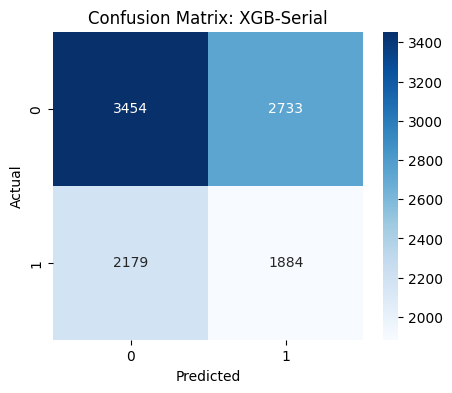

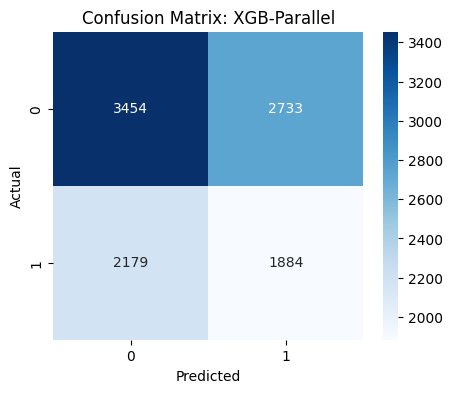

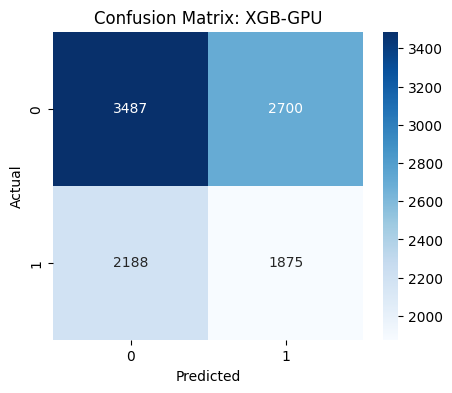

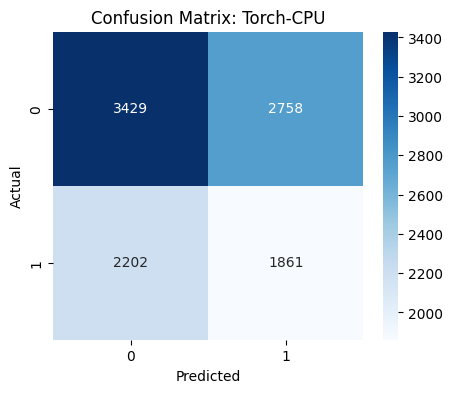

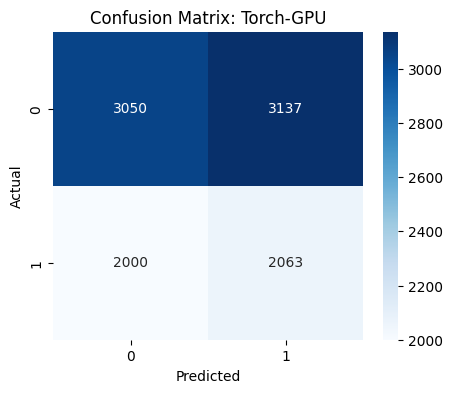

In [29]:
# 7. Confusion Matrix Plot
models = ['XGB-Serial', 'XGB-Parallel', 'XGB-GPU', 'Torch-CPU', 'Torch-GPU']
results = [xgb_serial_results, xgb_parallel_results, xgb_gpu_results, pytorch_cpu_results, pytorch_gpu_results]

for model_name, result in zip(models, results):
    plt.figure(figsize=(5,4))
    sns.heatmap(result[2], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# _______________________________________________________________-

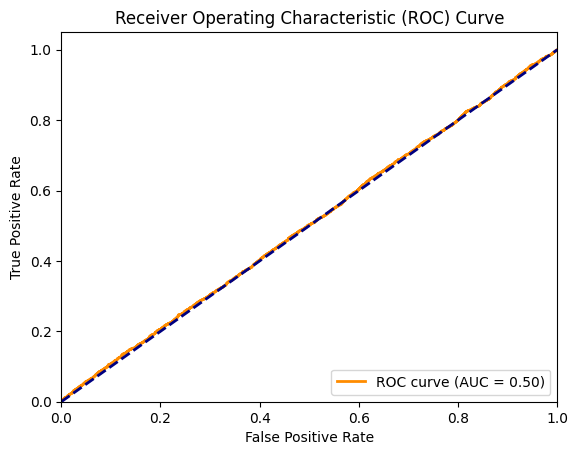

In [30]:
model_gpu.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculations
    y_pred_proba = model_gpu(X_test_tensor.to(device)).cpu().numpy()  # Predictions

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)  # Calculate ROC curve
roc_auc = auc(fpr, tpr)  # Calculate AUC

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

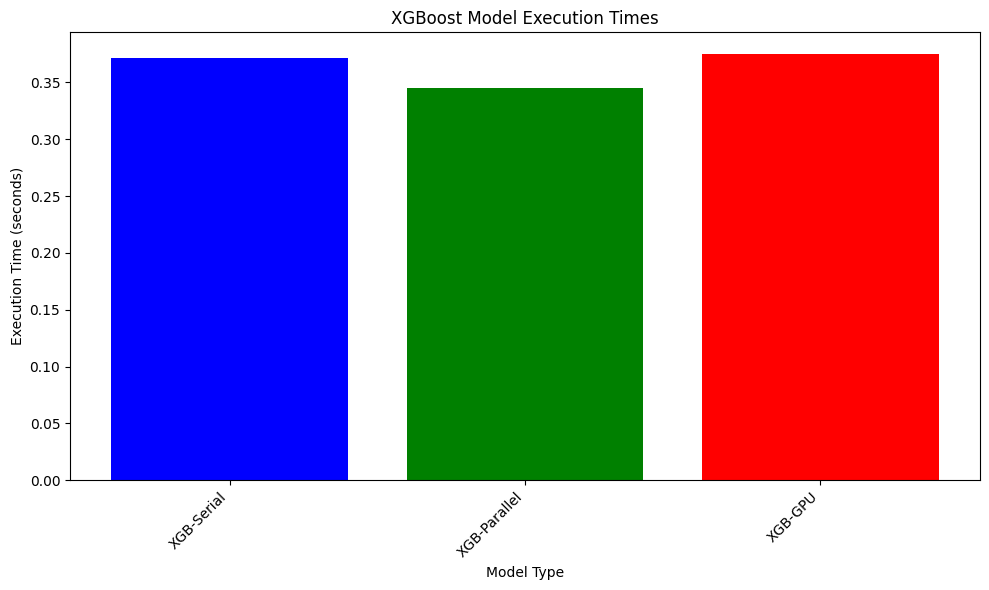

In [31]:
models = ['XGB-Serial', 'XGB-Parallel', 'XGB-GPU']
execution_times = [serial_time, parallel_time, gpu_time]

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(models, execution_times, color=['blue', 'green', 'red'])
plt.title('XGBoost Model Execution Times')
plt.xlabel('Model Type')
plt.ylabel('Execution Time (seconds)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

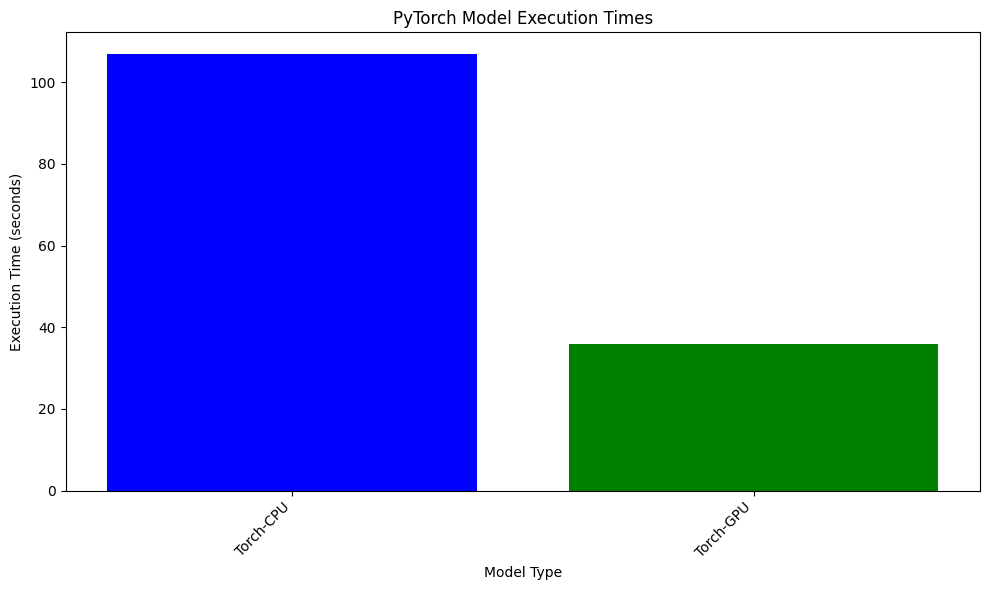

In [32]:
models = ['Torch-CPU', 'Torch-GPU']
execution_times = [cpu_train_time, gpu_train_time_nn]

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(models, execution_times, color=['blue', 'green'])
plt.title('PyTorch Model Execution Times')
plt.xlabel('Model Type')
plt.ylabel('Execution Time (seconds)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability if needed
plt.tight_layout()
plt.show()